# Can we predict strain type (sativa/indica) from strain descriptions?

In [1]:
# GENERAL
import numpy as np
import pandas as pd

# NLP
from collections import Counter
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# MODELING
from sklearn import metrics, tree, linear_model, neighbors, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold

# GRAPHICS
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 0. Load df, set columns

In [2]:
# LOAD df, SET COLUMNS
df_raw = pd.read_csv('data/df_strain_me_v2.csv', encoding = "UTF-8")

cols = ['strain', 'cluster', 'lean', 'strain_type', 'Strain_description']
df = df_raw[cols].copy()
df.columns = ['Strain', 'Cluster', 'Lean', 'Strain_type', 'Strain_description'] # Rename columns
df.index = df['Strain']
df.drop('Strain', axis=1, inplace=True)

# REMOVE NULL Strain_description columns
df.dropna(subset=['Strain_description'], inplace=True)
df.head()

Cluster  Lean Strain_type  \
Strain                                             
$100 OG                      0  0.50      hybrid   
'98 Aloha White Widow        2  0.57      hybrid   
1024                         0  0.30      sativa   
13 Dawgs                     0  0.50      hybrid   
22                           0  0.54      hybrid   

                                                      Strain_description  
Strain                                                                    
$100 OG                $100 OG is a 50/50 hybrid strain that packs a ...  
'98 Aloha White Widow  The  98 Aloha White Widow is an especially pot...  
1024                   1024 is a sativa-dominant hybrid bred in Spain...  
13 Dawgs               13 Dawgs is a hybrid of G13 and Chemdawg genet...  
22                     22 is a Jack Herer cross from Cali Connection....

Let's also remove from each strain description any mentions of any strains in the dataframe.

In [3]:
# REMOVE ALL STRAIN NAMES FROM Strain_description TEXT
strain_names = list(df.index.values)
strain_names.sort(key=lambda strain_names: len(strain_names.split()), reverse=True) # Sort names by word length

df_nonames = df.copy()
old_descriptions = df['Strain_description'].values
new_descriptions = []

# FOR EACH STRAIN NAME IN THE DESCRIPTION, REPLACE IT WITH ""
for i in old_descriptions:
    print("OLD TEXT: ", i)
    for name in strain_names:
        i = i.replace(name,"")
    new_descriptions.append(i)
    print("NEW TEXT: ", i)

# UPDATE df_nonames
df_nonames['Strain_description'] = new_descriptions
df_nonames['Strain_description']

OLD TEXT:  $100 OG is a 50/50 hybrid strain that packs a strong punch. The name supposedly refers to both its strength and high price when it first started showing up in Hollywood. As a plant, $100 OG tends to produce large dark green buds with few stems. Users report a strong body effect of an indica for pain relief with the more alert, cerebral feeling thanks to its sativa side.
NEW TEXT:   is a 50/50 hybrid strain that packs a strong punch. The name supposedly refers to both its strength and high price when it first started showing up in Hollywood. As a plant,  tends to produce large dark green buds with few stems. Users report a strong body effect of an indica for pain relief with the more alert, cerebral feeling thanks to its sativa side.
OLD TEXT:  The  98 Aloha White Widow is an especially potent cut of White Widow that has grown in renown alongside Hawaiian legends like Maui Wowie and Kona Gold. This White Widow phenotype reeks of diesel and skunk and has a rich earthy taste wi

NEW TEXT:   from Alpha Medic is an  phenotype that took 2nd place in the 2014 Los Angeles Cannabis Cup. Its thick layer of crystal trichomes helps to explain why this pungent, pine-scented strain consistently tests over 20% THC when grown optimally. Conditions best treated with high-THC strains like  include sleep apnea, appetite and weight loss, nausea, and chronic pain.
OLD TEXT:  Alpine Blue is a 60/40 sativa-dominant hybrid that combines Blue Mystic and Power Plant, who pass on uplifting euphoric effects alongside a complex aroma of blueberry and woody pine. While some phenotypes tend toward the indica side of the spectrum, even its common sativa expression induces calming full-body effects. Patients typically look to Alpine Blue for daytime relief of anxiety and mood disorders, gastrointestinal pain, and inflammation.
NEW TEXT:   is a 60/40 sativa-dominant hybrid that combines  and , who pass on uplifting euphoric effects alongside a complex aroma of blueberry and woody pine. Whil

NEW TEXT:   (also known simply as Black Magic) is an indica-dominant strain with mysterious and arcane genetics. With jade green foliage and bright orange pistils,  looks nearly as good as it tastes. Exhibiting a terpene profile soaked in sweetness, berry, and herbaceous overtones,  delivers a pleasurable variety of flavors, aromas, and effects that help nullify stress and encourage rest. Utilize this strain at the end of the day to make the most of its sleep-inducing qualities.
OLD TEXT:  Black Mamba is named after the deadly African snake (or perhaps the vengeful bride from the movie Kill Bill), so it's no surprise that this strain is known for being strong (it might just knock less experienced users into nap time). The genetics of this strain are unknown, but its characteristics seem to support the theory that it is a descendent of Granddaddy Purple and maybe Black Domina. These plants produce dark green to purple leaves, but it's the flowers that appear after about 8 weeks that rea

NEW TEXT:   is a rendition of  distributed by Canadian LP Tweed that delivers hefty euphoric effects suitable for consumers with a high cannabis tolerance. As you might expect from an  flower,  smells earthy and woody like a pine tree, with subtle hints of sour lemon. The high THC content of  makes this hybrid strain particularly useful for patients treating PTSD, nausea, pain, and stress.
OLD TEXT:  Boggle Gum is a relaxing hybrid cross between Northern Lights #5 and BOG Bubble.
NEW TEXT:   is a relaxing hybrid cross between  and .
OLD TEXT:  Booger may not have an appetizing name, but a look at this hybrid's genetics may be all the convincing you need to give this strain a try: Strawberry Cough combines with Bubba Kush to create a balanced effect that walks the line between physical relaxation and cerebral energy. This Colorado native introduces itself with a sweet berry and sour skunk aroma while earthy, hashy flavors are detected on the exhale. With uplifting and calming effects, B

Though this hybrid is sativa-dominant, it provides consumers with a very well-balanced buzz. Sagan is great for anyone looking for a strain that's strong but not overwhelming. This strain also features a tropical aroma, with lingering tastes of guava and passion fruit.
OLD TEXT:  Carnival by Ministry of Cannabis is a sativa-dominant strain designed to translate the eccentric, colorful vibe of Carnival from the streets of Brazil into the mind of the consumer. This cerebral strain gets its powerful mental effects from its select Haze mother and its unknown sativa-hybrid father. The scents of citrus and lemon candy explode off the lanky spears created by this plant. Know to thrive both indoors and outdoors, Carnival has a snappy flowering time of only nine weeks. This strain's upbeat euphoria and general mood alteration makes it a great social strain to share among friends.
NEW TEXT:   by Ministry of Cannabis is a sativa-dominant strain designed to translate the eccentric, colorful vibe o

NEW TEXT:   by  Seeds combines a resinous  hybrid with the heavy-hitting indica . This mostly indica strain rewards growers with high yields of fruity, crystal-packed buds that finish flowering in 7 to 9 weeks.
OLD TEXT:  Critters Cookies blends the power of Cookies' parentage with the energy driven hybrid White Fire Alien OG to offer an aroma of distinct lemon funk with a sweet cakiness that lingers in the air. The strain is a balanced 60/40 sativa-leaning cross that is equal parts energizing and relaxing, and is naturally suited for physical discomfort and pain.
NEW TEXT:   blends the power of Cookies' parentage with the energy driven hybrid  to offer an aroma of distinct lemon funk with a sweet cakiness that lingers in the air. The strain is a balanced 60/40 sativa-leaning cross that is equal parts energizing and relaxing, and is naturally suited for physical discomfort and pain.
OLD TEXT:  Cronuts is another twist on the West Coast wonder, Girl Scout Cookies. Created by Alphakronik

NEW TEXT:   is a sativa variety bred by Paradise Seeds.  She loves warmer climates and can grow as high as 9 feet tall outside so make sure you have ample vertical room.
OLD TEXT:  Dutch Hawaiian is a sativa strain that is lime green in color. With a citrus taste, this strain provides a good body high.
NEW TEXT:   is a sativa strain that is lime green in color. With a citrus taste, this strain provides a good body high.
OLD TEXT:  Dutch Haze by Dutch Passion is a 90% sativa-dominant strain crafted for Haze lovers everywhere.  Born  in 2009, Dutch Haze is the product of hundreds of Haze plants and several years of breeding both American Haze and Dutch Haze genetics in search of the perfect phenotype. This strain has a spicy aroma with notes of citrus, earth, and tropical fruit. The stalks grow tall and abundant with an average flowering time of approximately 10 weeks. Dutch Haze offers consumers a strong cerebral energy with uplifting and creative qualities to help take the edge off of 

NEW TEXT:   is a mostly sativa strain from Heavyweight Seeds, who bred this flavor powerhouse from Skunk, , and  genetics. Named for its swift hit of sweet fruity and tropical flavors, this sativa has something to offer in both taste and effect.  charges the mind with creative and social energy, so keep this strain in your stash jar for active days spent with friends or personal hobbies.
OLD TEXT:  Fruit Spirit is a 60% sativa-dominant hybrid that was bred by Royal Queen Seeds through crossing Blueberry and White Widow. This is a match made in heaven, as Fruit Spirit inherits a pleasant blueberry aroma and White Widow's heavy resin production. A sense of happiness eases the mind in total cerebral relaxation, making Fruit Spirit suitable for patients treating mood disorders, anxiety, or depression. This sweet-smelling hybrid flowers in 7 to 8 weeks indoors, but outdoor gardens should only be grown in warm, sunny regions.
NEW TEXT:   is a 60% sativa-dominant hybrid that was bred by Royal

NEW TEXT:  This potent sativa was developed by crossing  with a fast-flowering sativa selected for its rich grapefruit flavor. The tropical, citrus smell of  mixes with energetic effects to give you a happy stress-reliever that also works well for battling migraine headaches.
OLD TEXT:  Grapefruit Diesel is a hybrid strain that is usually indica-dominant but gives most users a focused mental high that is more commonly associated with sativas. The genetics on this one aren't hard to guess: its parents are Grapefruit and NYC Diesel. These plants show more of their indica side when growing, staying short and branchy and flowering within 8 weeks. Grapefruit Diesel's flowers sometimes have hints of pink coloring and a potent smell of over ripe citrus fruit. With THC levels between 15 and 20%, the effects should be as strong as the scent. The energetic buzz comes on fast but tends to smooth out over time.
NEW TEXT:   is a hybrid strain that is usually indica-dominant but gives most users a f

NEW TEXT:  An indica-dominant cross between  and ,  is a California strain bred with the stalwart cannabis veteran in mind. Its dense, pungent buds produce thick coats of resin that can be extracted for potent (and we mean potent) concentrates. The weight of this sedating indica sinks throughout the body, submerging stress, pain, and other ailments under its crushing THC content.
OLD TEXT:  Harle-Tsu, bred by the Southern Humboldt Seed Collective, is a high-CBD hybrid cross between Harlequin and Sour Tsunami. With a CBD content 20 times higher than its THC content, Harle-Tsu brings relief to pain and inflammation without psychoactivity. Harle-Tsu seeds have a 75% chance of expressing its high-CBD characteristics, and indoor plants will finish flowering in 8 weeks.
NEW TEXT:  , bred by the Southern  Seed Collective, is a high-CBD hybrid cross between  and . With a CBD content 20 times higher than its THC content,  brings relief to pain and inflammation without psychoactivity.  seeds hav

NEW TEXT:  Don't worry,  isn't some strange affliction you may get from hanging around with flower children, it's an uplifting sativa-dominant hybrid. Patients love this cross of  and  for its sweet smell and taste. Take this Hippie home and you'll be glad you did. While this strain is popular for daytime, it may leave some patients bleary-eyed and a little spacey depending on tolerance and dosage.
OLD TEXT:  Winner of the 2002 Cannabis Cup for best indica, Hog's breath was bred from Hindu Kush and Afghani in Tennessee. Her buds are light and dark green with orange hairs and a healthy amount of crystals on its dense buds. The taste has been described as cheddar and provides a overall tingly mind and body high. The THC content is up to 13% and CBD up to 0.47%.
NEW TEXT:  Winner of the 2002 Cannabis Cup for best indica, Hog's breath was bred from  and  in Tennessee. Her buds are light and dark green with orange hairs and a healthy amount of crystals on its dense buds. The taste has been 

NEW TEXT:  , or Wiz Khalifa OG,  is a hybrid that was bred specifically for the rap artist Wiz Khalifa, who claims it descended from an OG strain. The  real'  is supposedly unavailable to the public, but those who have acquired strains under this name say that the effects and aromas are similar to that of : sour lemon and pine, with an active cerebral buzz ideal for morning and daytime use.
OLD TEXT:  Khufu is an indica-dominant hybrid from The Devil's Harvest Seed Company that combines Cheese, Afghani #1, and SFV OG genetics to excellent effect. Growers can expect extremely high yields of potent Kush-type flowers, with giant calyxes and very little leaf. The effects of Khufu will leave you wanting nothing more than to gorge on snacks while glued to your favorite chair. Patients treating pain, anxiety, nausea, and insomnia may benefit from Khufu's therapeutic effects.
NEW TEXT:   is an indica-dominant hybrid from The Devil's Harvest Seed Company that combines ,  #1, and  genetics to ex

NEW TEXT:  The general consensus surrounding  is that is a cross between  and Lemon Joy. However, breeder specific variations exist. Alien Genetics, for example, explains their  as a hybrid between , a prized strain from Ohio, and an . The genetics are the only area of dispute as everyone will agree that the sweet flavors of lemon and citrus mix exceptionally well with the earthy kush undertones. The light green buds are covered in a white frosting of trichomes and provide uplifting and creative effects.  is the perfect solution for when the stresses of life have you feeling sour.
OLD TEXT:  Lemon Larry Lavender by Big Buddy Seeds is greater than the sum of its parts. The stunningly flavorful cross of Lemon Larry OG Kush and Lavender offers sweet citrus aromas overlaid by velvety floral terpenes. With loosely sedative effects brought on by the Lavender and an elevated mental state from the concentration of limonene, Lemon Larry Lavender pairs perfectly with video games and movie nights

NEW TEXT:   refers to the indigenous varieties of cannabis (or landraces) that grow natively in this region of the world. Because of this region's latitude and climate, these native landrace strains tend to be sativa in structure and effect.
OLD TEXT:  Mexican Sativa is a 70/30 sativa-dominant hybrid that offers an uplifting, clear-headed buzz alongside a fresh sandalwood aroma. To reduce the plant's flowering time, Sensi Seeds breeders crossed a cultivar from the southern province of Oaxaca with the hardy African sativa Durban Poison and a fast-flowering Pakistani indica.
NEW TEXT:   is a 70/30 sativa-dominant hybrid that offers an uplifting, clear-headed buzz alongside a fresh sandalwood aroma. To reduce the plant's flowering time, Sensi Seeds breeders crossed a cultivar from the southern province of Oaxaca with the hardy  sativa  and a fast-flowering Pakistani indica.
OLD TEXT:  When word got out that the Olympic gold medalist enjoyed cannabis, it was only a matter of time before a 

NEW TEXT:  Named after its breeder,  is reported to be a solid, potent indica that induces spacey cerebral effects and and indica-typical, heavy body sensations. This strain differs in its exceptional appearance: the plant's flowers are puffy and emerald with balanced coverage in soft orange hairs. The aroma is pungent and of the jet fuel category; similarly, it delivers on the harsh side with a rich, lingering aftertaste.  induces strong, long-lasting effects that are useful when heavily medicating.
OLD TEXT:  NukeHeads is a bold and varied hybrid created by NukeHeads' owner and breeder, Cody Oebel. Known to produce massive plants, NukeHeads emits a primarily citrus and herbal aroma, giving off notes of lemon and hops. The strain's flavor is tart and pungent, exhibiting skunky flavors with herbal undertones. Its effects tend to stimulate appetite and imbue consumers with a giggly aura.
NEW TEXT:   is a bold and varied hybrid created by ' owner and breeder, Cody Oebel. Known to produce

NEW TEXT:   goes by many names, including Wow Kush, , Phantom ( or Ken's Phantom). Bred in the Bay area by Ken Estes, who crossed Ken's  and , this sedative beauty is not to be confused with . The buzz lands behind the eyes and emanates outwards, making this a suitable strain for patients suffering from migraines and physical discomfort. With notes of grape and berry, this strain imbues smokers with weighted eyes and a  couch lock  effect, making it a pre-sleep ripper useful for insomnia.
OLD TEXT:  Pink Cookies, also known as Wedding Cake, is the familial genetic cross of Girl Scout Cookies and Cherry Pie. This delectable treat is rich with tangy sweet earth and pepper, taking notes and dimension from its OG and Durban Poison parentage. Enjoy this double dose of dense dankness with care, as certain farms have noted THC content upwards of 25% or greater.
NEW TEXT:  , also known as , is the familial genetic cross of Girl Scout Cookies and . This delectable treat is rich with tangy sweet

NEW TEXT:   is an indica-dominant hybrid created by crossing Nepali OG and , two descendants of classic landrace strains from Nepal and India. The smell is reminiscent of berries, black cherries, strawberries, and  punch while its flavor is fruity with notes of spice. You can expect sedative effects that will leave you melting into the couch as your eyes grow heavy.
OLD TEXT:  Queen's Panties is a royally stimulating sativa-dominant that charges the body with a palpable energy. This energy is worn on consumers like regal cape that flows behind them as they bound from place to place, visibly lit up by this cross of Dream Queen and Purple Panty Dropper. Invigoration begins in the mind and works its way through the body with continued consumption. The Purple in this strain can cause relaxing effects in some, but overall, remains alert yet hazy. Enjoy this cut alongside physical activity to harness the best it has to offer.
NEW TEXT:   is a royally stimulating sativa-dominant that charges 

OLD TEXT:  Everything's bigger in Texas, and if you talk to devotees of this Lone Star State strain, they'll tell you that the marijuana is better, too. Shoreline is a strain of legend. Supposedly first appearing in the early 1980s, it is known as a true  old school skunk.  Fittingly, its name is rumored to come from the state's Shoreline amphitheater after the strain made a successful debut there during a Grateful Dead concert. Its super strong skunky smell may border on unappetizing, but its large, hairy buds make up for it with equally potent effects. Sativa-dominant, this strain will free your mind and may verge into the psychedelic for some. A clone-only plant, true connoisseurs wonder if the original can still be found. In an effort to continue its lineage, Shoreline has been crossed with many other strains. If it's found outside of its Texas homeland, a mix is probably what you're getting.
NEW TEXT:  Everything's bigger in Texas, and if you talk to devotees of this Lone Star Sta

NEW TEXT:   is a high-CBD strain bred from  and  parents. This hybrid is appreciated by medical patients for its relaxing effects that calm pain and stress without losing focus.
OLD TEXT:  StarBud is the signature indica of the HortiLab seedline. After taking the Indica Cup at the High Times Cannabis Cup in 2009, StarBud developed a reputation for its thick coating of trichomes that sparkles like stars. This potent indica originated from a mystery clone out of the Midwest United States. StarBud is appreciated for its relaxing body effects and its ability to cradle consumers to sleep.
NEW TEXT:   is the signature indica of the HortiLab seedline. After taking the Indica Cup at the High Times Cannabis Cup in 2009,  developed a reputation for its thick coating of trichomes that sparkles like stars. This potent indica originated from a mystery clone out of the Midwest United States.  is appreciated for its relaxing body effects and its ability to cradle consumers to sleep.
OLD TEXT:  Starda

NEW TEXT:  A predominantly indica variety,  takes its robust flowers from its parent strain Skunk #1. By backcrossing the legendary Skunk with  genetics, Sensi Seeds created a strain with dense, thick buds that are known to be extremely pungent with a surprisingly sweet taste. This strain produces a bold relaxing effect over the body and is a great answer for increased stress and body pains.
OLD TEXT:  Super Snow Dog, also known as Snow Dawg or G6,  is a sativa-dominant strain from the Chemdawg family. This fast-flowering strain has a sweet fruity and citrus aroma, and patients typically choose Super Snow Dog for daytime relief of stress and tension.
NEW TEXT:  , also known as Snow Dawg or G6,  is a sativa-dominant strain from the Chemdawg family. This fast-flowering strain has a sweet fruity and citrus aroma, and patients typically choose  for daytime relief of stress and tension.
OLD TEXT:  Taking after its popular parents, Super Sour Diesel is one incredible sativa. A potent cross b

NEW TEXT:   is a chocolatey, citrus blend of  and , two of DNA Genetics' best sativas. It is best known for its intense terpene profile and exotic smell. The cerebral effects evoke happiness, giggles, and can stimulate creativity.
OLD TEXT:  Tango Kush by Potbox is a Mango Kush cross offering sweet funkiness in droves. With random forest aromas mixed in with the tart fruit, the smell of this strain is complex and pleasant. In traditional Kush fashion, Tango Kush offers a mid-level cerebral introspection alongside easy body effects. This strain remains functional in small to medium doses, but leans back into deep relaxation with heavy use.
NEW TEXT:   by Potbox is a  cross offering sweet funkiness in droves. With random forest aromas mixed in with the tart fruit, the smell of this strain is complex and pleasant. In traditional Kush fashion,  offers a mid-level cerebral introspection alongside easy body effects. This strain remains functional in small to medium doses, but leans back into

NEW TEXT:   is a delicious, sleep-inducing cross of  and .  possesses strong indica-dominant genetics, including  and , which are amplified by the sweet and floral elements of . This sedating combination lays into the body, weighing the consumer down with potent relaxation ideal for late evenings. Enjoy  to help relieve restlessness, anxiety, and general pain while stimulating introspective thought.
OLD TEXT:  Ultra Sonja is a sativa-dominant descendant of U.K. Cheese and Tang Tang that inherits an unusual blend of flavor and effects from its parent strains. Like a pairing of wine and cheese, Ultra Sonja combines a sour funky aroma with deep fruity accents in a display of its heritage. Its dense buds, which sometimes express themselves in tones of purple, deliver clear-headed feelings of bliss and tranquility.
NEW TEXT:   is a sativa-dominant descendant of U.K.  and Tang Tang that inherits an unusual blend of flavor and effects from its parent strains. Like a pairing of wine and cheese

NEW TEXT:   is a  landrace preserved and sold by World of Seeds. This 100% sativa landrace hails from the Ko Chang archipelago and offers consumers rich citrus flavors and exhilarating physical effects. Its flowers are dressed in bright orange hairs and a thick white coat of trichomes that contrasts dramatically against the deep emerald hue of the foliage.  is profoundly stimulating and should be avoided by those prone to anxiety. But for consumers looking for dizzying euphoria and stimulating physical effects through-and-through,  is the strain for you.
OLD TEXT:  Willie Nelson is a mostly sativa cannabis strain that is lauded for its euphoric, creative effects. The plants are sativa in their growing characteristics and should flower between 10 and 14 weeks. Flowers will be large but somewhat dense. Winner of the 2005 High Times Cannabis Cup in the sativa category, Willie Nelson has a fan base to rival its namesake's. Consumers love that this strain leaves them clear-headed, allowing 

Strain
$100 OG                    is a 50/50 hybrid strain that packs a strong ...
'98 Aloha White Widow     The  98   is an especially potent cut of  that...
1024                       is a sativa-dominant hybrid bred in Spain by ...
13 Dawgs                   is a hybrid of  and Chemdawg genetics bred by...
22                         is a  cross from Cali Connection. This extrem...
24k Gold                  Also known as ,  is a 60% indica-dominant hybr...
3 Bears OG                 by Mephisto Genetics is an autoflowering cros...
3 Kings                   The  marijuana strain, a holy trinity of , , a...
303 OG                    The indica-dominant  is a Colorado strain bred...
3D CBD                     from Snoop Dogg's branded line of cannabis st...
3X Crazy                  Also known as Optimus Prime, the indica-domina...
3rd Coast Panama Chunk     by Bedford Grow is a cross between East Coast...
501st OG                  , bred by Rare Dankness, is an indica-dominant...
5th E

## 1. Get the most common terms / TF-IDF for strain descriptions with Count Vectorizer

In [4]:
# SET STOPWORDS
stop_words=stopwords.words('english')

In [5]:
# INSTANTIATE COUNT VECTORIZER
# SET COUNT VECTORIZER'S TOKENIZER AS LEMMATIZER

class LemStemTokenizer(object):
    def __init__(self):
        self.lem = WordNetLemmatizer()
        self.stem = SnowballStemmer('english') # IF YOU WANT TO STEM
    def __call__(self, doc):
        # RETURN WITHOUT STEMMING W/O STOPWORDS
#         return [self.lem.lemmatize(t) for t in word_tokenize(doc) if t not in stop_words]
        # RETURN WITH STEMMING W/O STOPWORDS
        return [self.stem.stem(self.lem.lemmatize(t)) for t in word_tokenize(doc) if t not in stopwords.words('english')]

cv = CountVectorizer(tokenizer=LemStemTokenizer(), strip_accents='unicode')

In [6]:
# USE COUNT VECTORIZER TO GET TOKENS FOR ALL DESCRIPTIONS

descriptions = df_nonames['Strain_description']

# APPLY COUNT VECTORIZER, CREATE DF WITH TOKEN COLUMNS
data_cv = cv.fit_transform(descriptions)
features = cv.get_feature_names()

# CREATE DF
data_df = pd.DataFrame(data_cv.toarray(), columns=features, index=descriptions.index)

# DROP NON-ALPHA COLUMNS
for f in features:
    if not f.isalpha():
        data_df.drop(f, axis=1, inplace=True)

In [7]:
data_df.shape

(2101, 4910)

In [8]:
data_df.head()

abandon  abat  abbrevi  abduct  abil  abl  abound  \
Strain                                                                     
$100 OG                      0     0        0       0     0    0       0   
'98 Aloha White Widow        0     0        0       0     0    0       0   
1024                         0     0        0       0     0    0       0   
13 Dawgs                     0     0        0       0     0    0       0   
22                           0     0        0       0     0    0       0   

                       absolut  abund  acapulco  ...  zappa  zealand  zero  \
Strain                                           ...                         
$100 OG                      0      0         0  ...      0        0     0   
'98 Aloha White Widow        0      0         0  ...      0        0     0   
1024                         0      0         0  ...      0        0     0   
13 Dawgs                     0      0         0  ...      0        0     0   
22                           0      1         0  ...      0        0     0   

                       zest  zesti  zion  zip  zippi  zombi  zone  
Strain                                                             
$100 OG                   0      0     0    0      0      0     0  
'98 Aloha White Widow     0      0     0    0      0      0     0  
1024                      0      0     0    0      0      0     0  
13 Dawgs                  0      0     0    0      0      0     0  
22                        0      0     0    0      0      0     0  

[5 rows x 4910 columns]

In [9]:
# NORMALZE (TF-IDF) - DIVIDE ROW BY ROW SUM

# CREATE norm_data_df (all floats)
norm_data_df = data_df.copy().astype(float)

# NORMALIZE norm_data_df
for row in range(len(norm_data_df)):
    if sum(data_df.iloc[row]) != 0:
        norm_data_df.iloc[row] /= sum(data_df.iloc[row])

In [10]:
norm_data_df.sum().head()

abandon    0.015152
abat       0.415143
abbrevi    0.014493
abduct     0.064390
abil       0.776981
dtype: float64

### 1.1 Explore the data: what are the 20 most common words in all strain descriptions?

In [11]:
# CREATE df_sum WHICH CONTAINS BOTH (a) ABSOLUTE TERM COUNT AND (b) TD-IDF FOR EACH TERM
# NB: df_sum CONTAINS DATA FOR ALL STRAINS

word_count = data_df.sum(axis=0)
tf_idf = norm_data_df.sum(axis=0)
data = pd.concat([word_count, tf_idf], axis=1).values
columns = ["Word_count", "TF_IDF"]

df_sum = pd.DataFrame(data=data, index=word_count.index, columns = columns)

In [12]:
# GET 20 MOST COMMON WORDS - SORT df_sum BY word_count
df_sum = df_sum.sort_values(by='Word_count', ascending=False)
df_sum.head(20)

Word_count     TF_IDF
strain       2694.0  73.986511
effect       1431.0  38.389136
hybrid       1193.0  37.209844
cross        1033.0  34.061460
aroma         903.0  24.403143
flavor        777.0  21.416084
indica        771.0  21.682354
genet         756.0  20.086909
sweet         725.0  19.891897
relax         723.0  19.571825
bud           665.0  17.334842
flower        628.0  15.529253
sativa        613.0  18.089296
seed          601.0  16.664689
bodi          541.0  14.156578
pain          524.0  13.631643
high          519.0  14.646871
bred          469.0  14.269958
cannabi       426.0  13.631767
consum        417.0  10.166291

For the most common words it appears as though Word_count and TF-IDF are nearly identical. We can just pick one method and use it without worrying too much.

In [13]:
data_df.to_csv('leafly_decription_words.csv')

## 2. Decision Tree: train a model to predict Strain_type from word count for each strain

First, let's remove our target terms from word_count ("hybrid", "sativa", "indica") - this will help to "blind" the reviews.

In [18]:
data_df_blind = data_df.drop(labels=["hybrid", "sativa", "indica"], axis=1)

Now let's get our absolute baseline (the majority class)

In [19]:
# Hybrid / Indica / Sativa baseline
len(df[df['Strain_type']=='hybrid'])/len(df)

0.5154688243693479

If we just choose "hybrid" - the most common result - we would be right about 52% of the time. Surely we can beat this.

In [20]:
# Indica / Sativa only baseline
len(df[df['Strain_type']=='indica']) / (len(df[df['Strain_type']=='sativa']) + len(df[df['Strain_type']=='indica']))

0.5834970530451866

Similarly, if we're just examining sativa and indica strains, choosing "indica" will result in us being correct about 58% of the time.

### 2.1 Single Decision Tree: Hybrid / Indica / Sativa

In [21]:
# DECISION TREE CREATOR FUNCTION USING K-FOLDS
# THIS WILL EXPLORE OVER THE HYPER_PARAMETER: MAX_DEPTH

def DT_iterate(X, y, max_depth, class_names):
    
    DT_train_scores = [0]*max_depth
    DT_test_scores = [0]*max_depth
    
    # Generate confusion matrices for each depth
    DT_confusion_matrices = [np.zeros([len(class_names), len(class_names)])]*max_depth

    # Iterate over all depths
    for depth in range(1,max_depth+1):
    
        # USE stratified k-folds TO GENERATE TRAIN/TEST SETS FOR CROSS-VALIDATION
        folds = StratifiedKFold(n_splits = 5)
        indices = folds.split(X,y) # SPLIT df, "X", stratified on y

        # For each fold
        for train_index, test_index in indices:
            X_train, X_test = X.iloc[train_index], X.iloc[test_index] # Set Train, Test X
            y_train, y_test = y[train_index], y[test_index] # Set Train, Test y
            
            # Instantiate, Fit DT_model
            DT_model = tree.DecisionTreeClassifier(max_depth = depth)
            DT_model.fit(X_train, y_train)

            # Generate predictions for confusion matrix, append to DT_confusion_matrices
            y_pred = DT_model.predict(X_test)
            confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
            DT_confusion_matrices[depth-1] = DT_confusion_matrices[depth-1] + confusion_matrix
    
            # Decision tree predict, evaluate, scaled by folds.n_splits-1            
            DT_train_scores[depth-1] += DT_model.score(X_train, y_train)*100/(folds.n_splits)
            DT_test_scores[depth-1] += DT_model.score(X_test, y_test)*100/(folds.n_splits)
            
    plt.figure()
    plt.plot(np.arange(1,max_depth+1), DT_train_scores, label="train")
    plt.plot(np.arange(1,max_depth+1), DT_test_scores, label="test")
    plt.xlabel("Depth")
    plt.ylabel("Accuracy score")
    plt.title("Accuracy scores for Decision Tree model")
    plt.legend()
    plt.show()
    
    return(DT_model, DT_train_scores, DT_test_scores, DT_confusion_matrices)

In [22]:
# DISPLAY CONFUSION MATRIX FOR ALL DEPTHS, PLOT WITH SEABORN HEATMAP

def display_cf_matrix(confusion_matrices, i):
    
    # DISPLAY CONFUSION MATRIX
    fontsize = 12
    plt.figure(figsize=(6,4))
    ax = sns.heatmap(confusion_matrices[i], annot=True)
    ax.set_title(f"Confusion matrix for depth {i+1}", fontsize=fontsize+4)
    ax.yaxis.set_ticklabels(class_names, fontsize=fontsize)
    ax.xaxis.set_ticklabels(class_names, fontsize=fontsize)
    plt.show()
    
    return None

Let's start our analysis by looking at a single decision tree for our three classes of strains: hybrid, indica, and sativa.

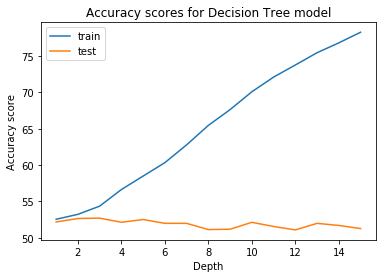

In [23]:
# ASSIGN X, y
X = data_df_blind
y = df['Strain_type']

class_names = ['hybrid', 'indica', 'sativa']

# GET DTs, SORES, CONFUSION MATRICES FOR EACH max_depth
max_depth = 15
DT_model, DT_train_scores, DT_test_scores, DT_confusion_matrices = DT_iterate(X, y, max_depth, class_names)

It looks like anything over a max depth of 2 (maybe even 1) would be constitute overfitting here. I suspect that this is because we're using K-folds (previous research, run with train_test_split, had train/test track until about max_depth = 5). However, we'll need to check the confusion matrices first befoew we can decide on a reasonable depth.

Let's check the accuracy scores for depth=2:

In [24]:
print(f"TRAIN ACCURACY, MAX DEPTH = 2: {round(DT_train_scores[1],3)}")
print(f"TEST ACCURACY, MAX DEPTH = 2: {round(DT_test_scores[1],3)}")

TRAIN ACCURACY, MAX DEPTH = 2: 53.213
TEST ACCURACY, MAX DEPTH = 2: 52.642


Our DT test accuracy is about 53%. This is barely an increase on our baseline of 52% (majority class).

Let's look at the confusion matrix for this model.

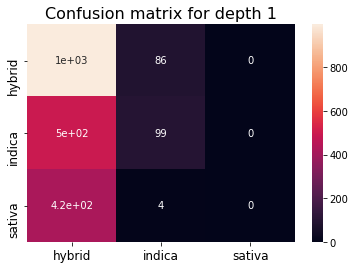

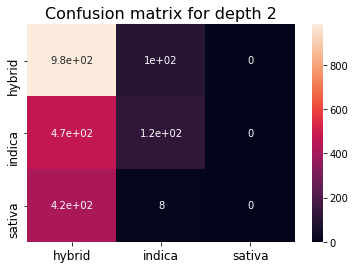

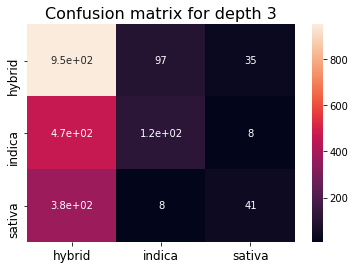

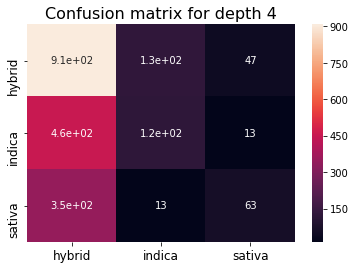

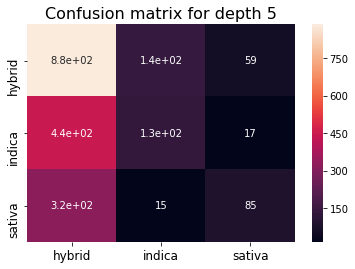

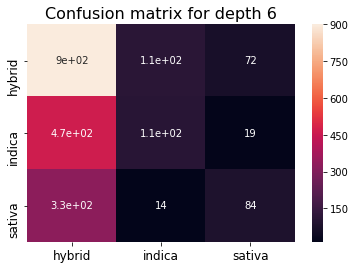

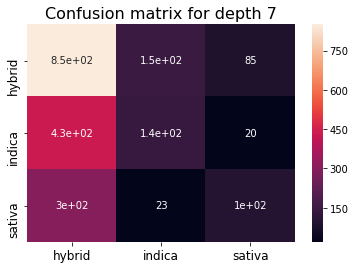

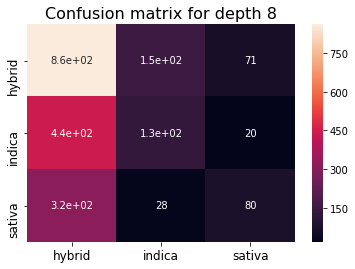

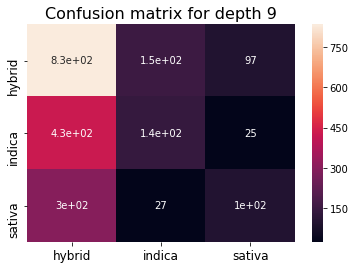

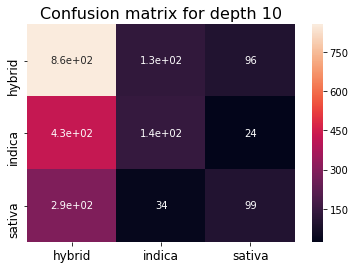

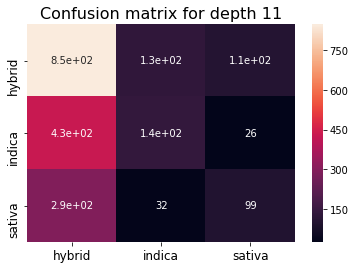

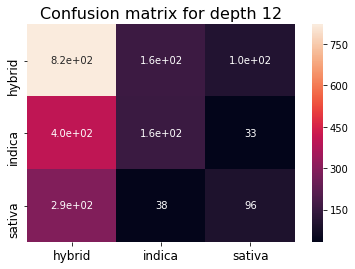

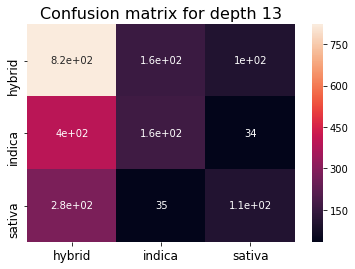

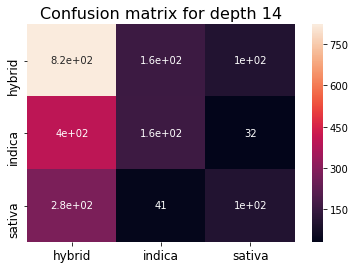

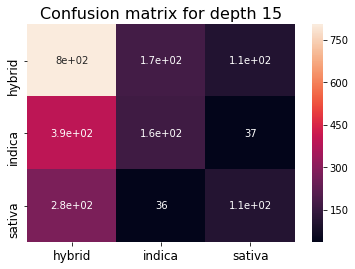

In [25]:
for i in range(0,max_depth):
    display_cf_matrix(DT_confusion_matrices, i)

It appears as our model is NOT learning to predict indica strains to a reasonable degree until at least depth 3 - depths 1 has no indica predictions at all!

That said, this model - even for higher depths - assigns more true sativas and indicas to "hybrid" than their correct class. This is a significant problem.

Interestingly, despite the confusion between hybrid and indica/sativa, there seems to be little confusion between indica and sativa. Let's see what happens if just train/predict on sativa/indica.

### 2.2 Single Decision Tree: Indica / Sativa only

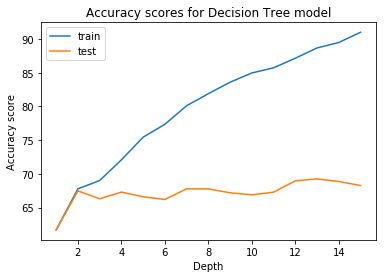

In [44]:
# DECISION TREE FOR SATIVA/INDICA ONLY

# ASSIGN X, y
sativa_indica_only = df[df['Strain_type'] != 'hybrid']

X = data_df_blind.loc[sativa_indica_only.index]
y = sativa_indica_only['Strain_type']

class_names = ['indica', 'sativa']

# GET DTs, SORES, CONFUSION MATRICES FOR EACH max_depth
max_depth = 15
DT_model, DT_train_scores, DT_test_scores, DT_confusion_matrices = DT_iterate(X, y, max_depth, class_names)

Focusing on sativa/indica is much more promising! At least our test results are increasing beyond a depth of 1.

A max depth of about 15 seems reasonable here. Let's look at accuracy scores and the confusion matrix for max depth = 15.

TRAIN ACCURACY, MAX DEPTH = 5: 81.90020234137882
TEST ACCURACY, MAX DEPTH = 5: 67.77615996893807


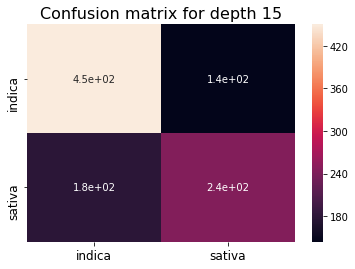

In [45]:
print(f"TRAIN ACCURACY, MAX DEPTH = 5: {DT_train_scores[7]}")
print(f"TEST ACCURACY, MAX DEPTH = 5: {DT_test_scores[7]}")
display_cf_matrix(DT_confusion_matrices, 14)

As we can see, this is a much more reasonable confusion matrix. Our accuracy for our test group is about 67.8%, which more cleanly beats our baseline of 58% by nearly 10%.

Now that we have results for a single decision tree, let's move onto random forests.

## 3. Random Forests: predict Strain_type from TF-IDF

As above, let's start with hybrid/indica/sativa and move on to indica/sativa.

### 3.1 Random Forest: Hybrid / Indica / Sativa

In [29]:
# RANDOM FOREST CREATOR FUNCTION USING K-FOLDS
# THIS WILL EXPLORE OVER THE HYPER_PARAMETERS : MAX_DEPTH, N_TREES

def RF_iterate(X, y, max_depth, n_trees, class_names, min_depth=1):
    
    RF_train_scores = [0]*(max_depth-min_depth+1)
    RF_test_scores = [0]*(max_depth-min_depth+1)
    
    # Generate a confusion matrices for each depth
    # RF_confusion_matrices[n] is the list of confusion matrices for n trees
    RF_confusion_matrices = [np.zeros([len(class_names), len(class_names)])]*(max_depth-min_depth+1)
            
    # Iterate over all depths
    for depth in range(min_depth,max_depth+1):

        # USE stratified k-folds TO GENERATE TRAIN/TEST SETS FOR CROSS-VALIDATION
        folds = StratifiedKFold(n_splits = 5)
        indices = folds.split(X,y) # SPLIT df, "X", stratified on y

        # For each fold
        for train_index, test_index in indices:
            X_train, X_test = X.iloc[train_index], X.iloc[test_index] # Set Train, Test X
            y_train, y_test = y[train_index], y[test_index] # Set Train, Test y

            # Instantiate, Fit RF_model
            RF_model = RandomForestClassifier(n_estimators=n_trees, max_depth=depth,\
                                          class_weight='balanced')
            RF_model.fit(X_train, y_train)

            # Generate predictions for confusion matrix, append to RF_confusion_matrices
            y_pred = RF_model.predict(X_test)
            confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
            RF_confusion_matrices[depth-min_depth] = RF_confusion_matrices[depth-min_depth] + confusion_matrix
            # RF predict, evaluate, scaled by folds.n_splits-1            
            RF_train_scores[depth-min_depth] += RF_model.score(X_train, y_train)*100/(folds.n_splits)
            RF_test_scores[depth-min_depth] += RF_model.score(X_test, y_test)*100/(folds.n_splits)
            
    plt.figure()
    plt.plot(np.arange(min_depth,max_depth+1), RF_train_scores, label = "train scores")
    plt.plot(np.arange(min_depth,max_depth+1), RF_test_scores, label = "test scores")
    plt.xlabel("Depth")
    plt.ylabel("Accuracy score")
    plt.title("Accuracy scores for Random Forest model")
    plt.legend()
    plt.show()
    
    return(RF_model, RF_train_scores, RF_test_scores, RF_confusion_matrices)

Let's examine our Random Forest for n_trees=200, max_depth=15.

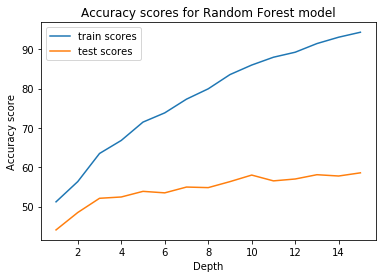

In [30]:
# Random Forest for SATIVA/INDICA/HYBRID
# n_trees = 200, max_depth = 15

X = data_df_blind
y = df['Strain_type']

class_names = ['hybrid', 'indica', 'sativa']

max_depth = 15
n_trees = 200

RF_model, RF_train_scores, RF_test_scores, RF_confusion_matrices = RF_iterate(X, y, max_depth, n_trees, class_names)

In [31]:
# GET TEST SCORE FOR max_depth (15)
print(f"Test score for max_depth = 15, n_trees = 200: {RF_test_scores[-1]}")

Test score for max_depth = 15, n_trees = 200: 58.585148901188404


Unlike our individual Decision Tree, our Random Forest's test data's accuracy increases consistently - albeit gradually - with depth. This is encouraging to see as it looks our model can actually learn from a greater depth.

Let's now check our confusion matrices.

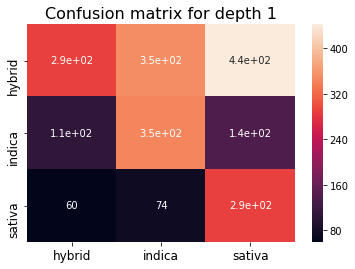

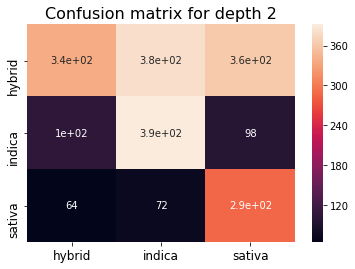

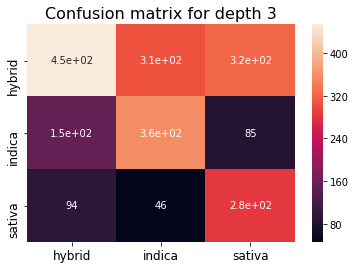

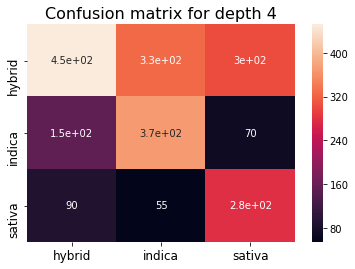

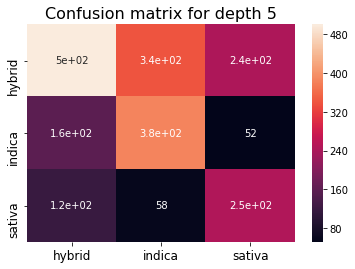

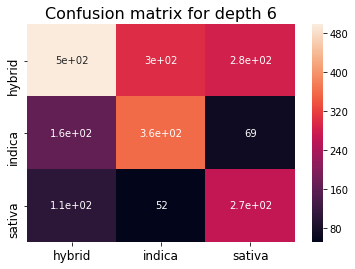

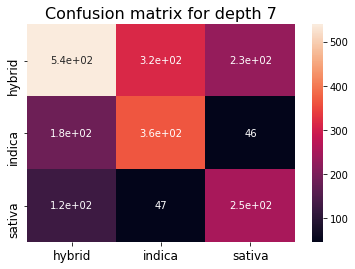

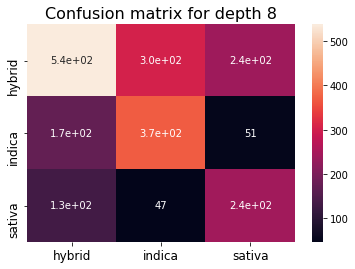

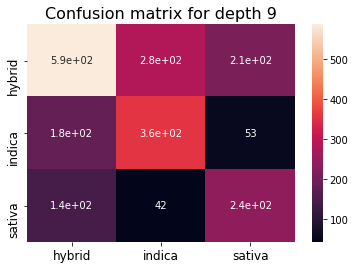

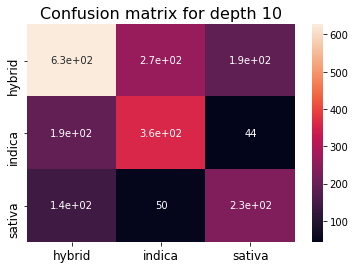

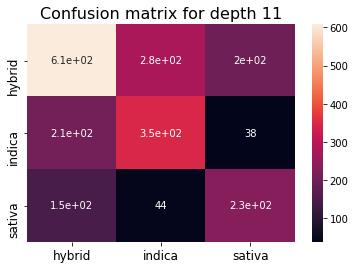

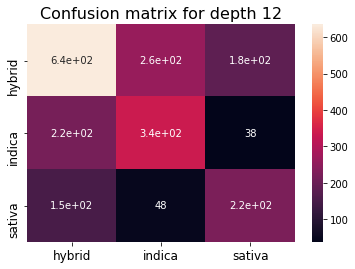

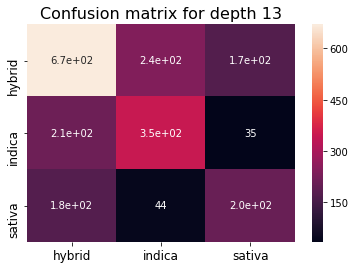

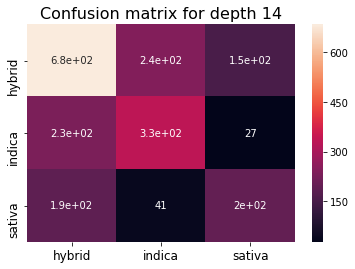

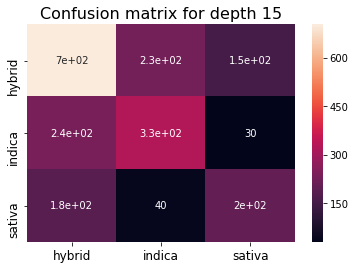

In [32]:
# Confusion Matrix
for i in range(0, max_depth):
    display_cf_matrix(RF_confusion_matrices, i)

Our confusion matrices show clear improvement (with expected variation) for subsequent depths! Again, this is promising.

However, as with our single decision tree, our while there is little confusion between sativa and indicas, these strains are often confused with hybris.

Let's check our results for a deeper and larger Random Forest: depth=50, trees=500. We'll check two depths below and above 50 for consistency/movement.

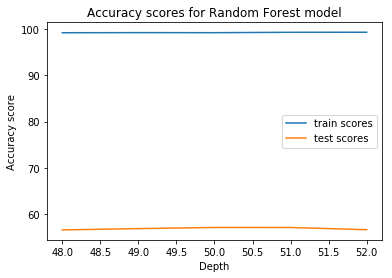

In [33]:
X = data_df_blind
y = df['Strain_type']

class_names = ['hybrid', 'indica', 'sativa']

min_depth = 48
max_depth = 52
n_trees = 500

RF_model, RF_train_scores, RF_test_scores, RF_confusion_matrices = RF_iterate(X, y, max_depth, n_trees, class_names, min_depth=min_depth)

In [34]:
print(RF_train_scores)
print(RF_test_scores)

[99.19083704182735, 99.21461120637032, 99.20274888568447, 99.28601147523707, 99.2979232938466]
[56.58967489983867, 56.874030249452176, 57.114967834182735, 57.11280739096715, 56.63809220741337]


A greater max_depth and more trees does not increase our test scores by a perceptible degree - depth=50, tree=500 is functionally equivalent to depth=15, trees=200, (56.6 vs 58.6, well within error/acceptible variation).

So it looks like we're topping out below 60% accuracy score for hybrid / indica / sativa. While this is a clear improvement on a single decision tree (53%), we will likely do better if we exclude hybrid strains and just focus on indica / sativa classification.

Let's now look at our confusion matrices.

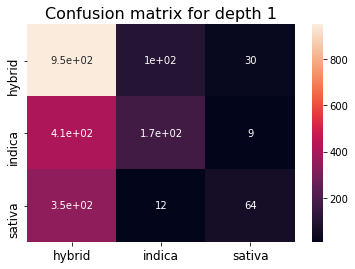

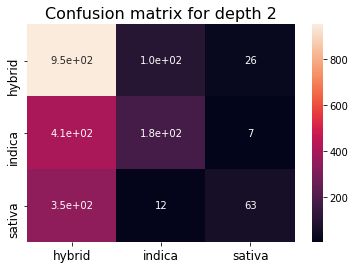

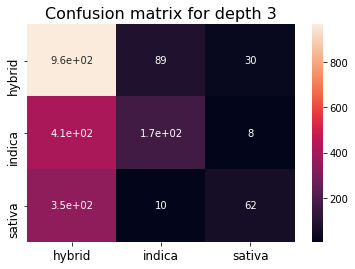

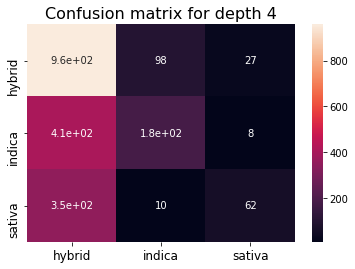

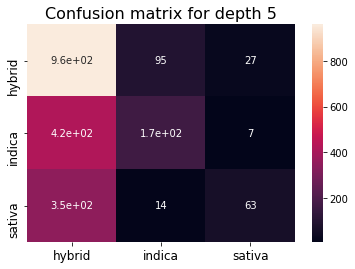

In [35]:
# Confusion Matrix
for i in range(0, max_depth-min_depth+1):
    display_cf_matrix(RF_confusion_matrices, i)

As before, more indica and sativa strains are classified as hybrid than their proper strain type. In fact, nearly all sativa strains are classified as hybrid! For better results we will surely have to look at indica/sativa only.

### 3.2 Random Forest: Indica / Sativa only

As with our decision tree, let's see if we can get obtain higher predictive accuracy by omitting "hybrid" strains. Let's also go deeper and use a max_depth of 25.

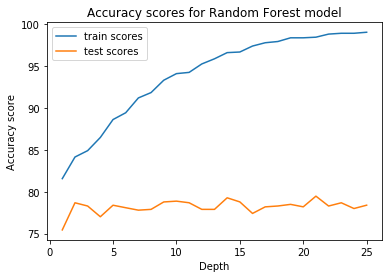

In [36]:
# Random Forest for Indica/Sativa classes, max_depth=25, n_trees = 200

sativa_indica_only = df[df['Strain_type'] != 'hybrid']

X = data_df_blind.loc[sativa_indica_only.index]
y = sativa_indica_only['Strain_type']

class_names = ['indica', 'sativa']

max_depth = 25
n_trees = 200

RF_model, RF_train_scores, RF_test_scores, RF_confusion_matrices = RF_iterate(X, y, max_depth, n_trees, class_names)

In [37]:
print(np.mean(RF_test_scores[5:15]), np.mean(RF_test_scores[10:20]), np.mean(RF_test_scores[15:25]), np.mean(RF_test_scores[5:25]))

78.3948747815958 78.3097456804504 78.33983692486895 78.36735585323238


The accuracy stores start around 78.3 and seem to waver only very slightly. Let's check the confusion matrics.

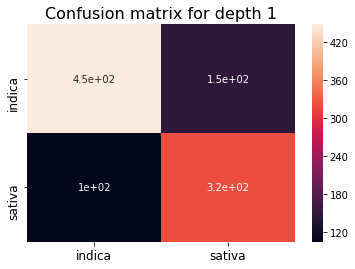

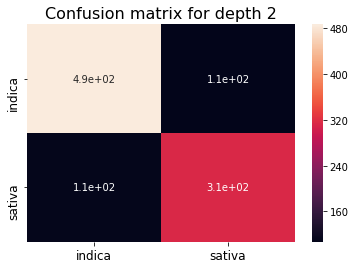

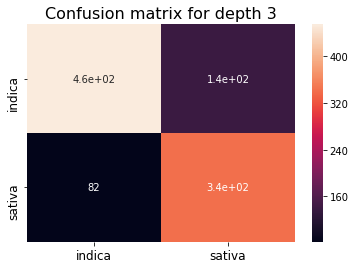

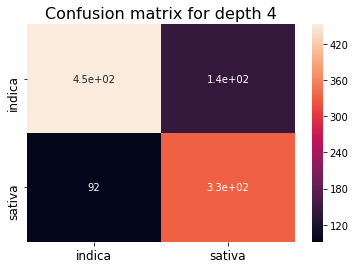

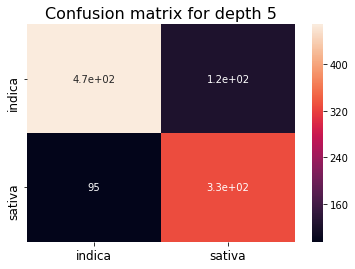

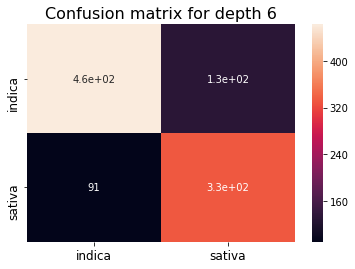

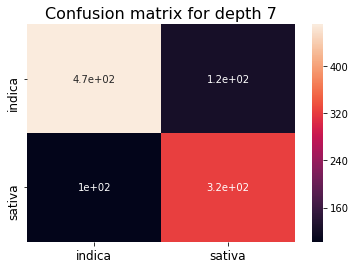

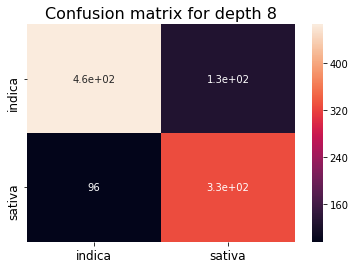

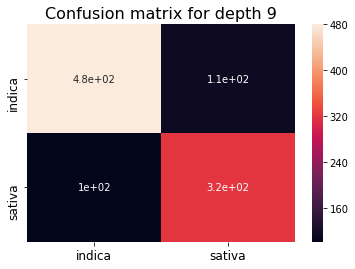

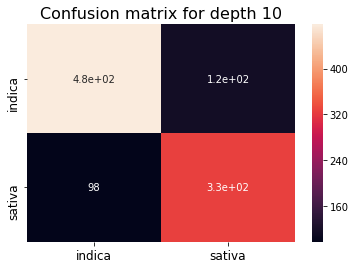

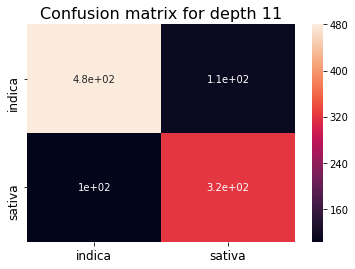

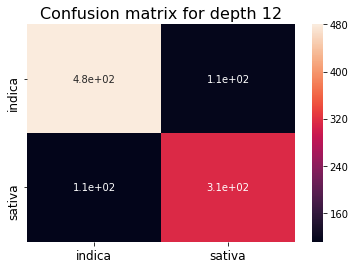

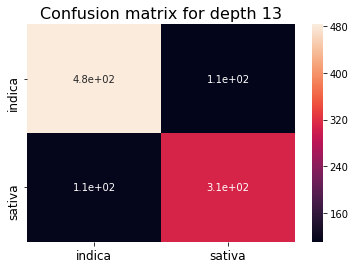

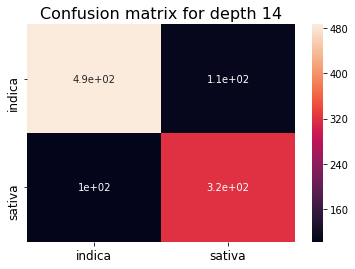

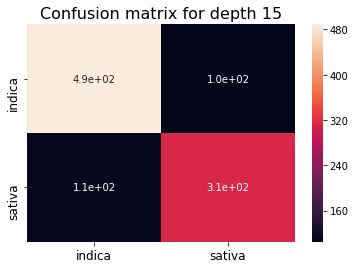

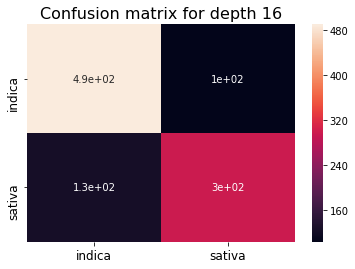

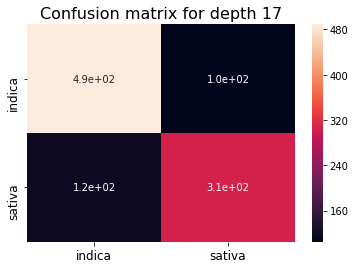

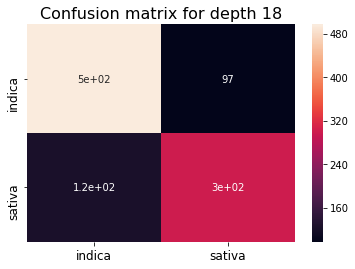

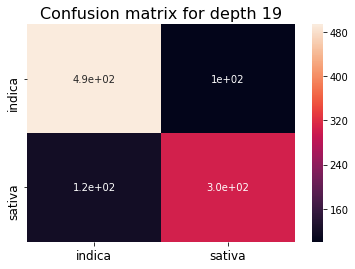

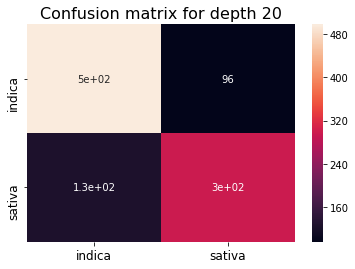

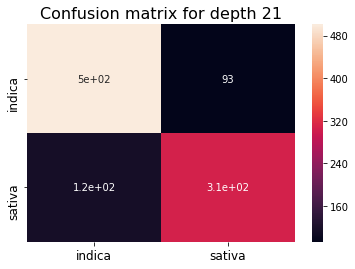

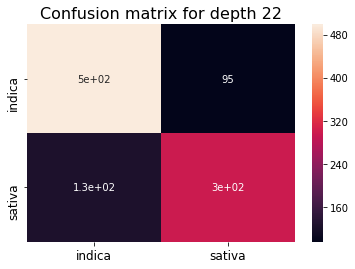

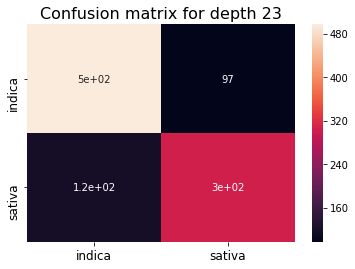

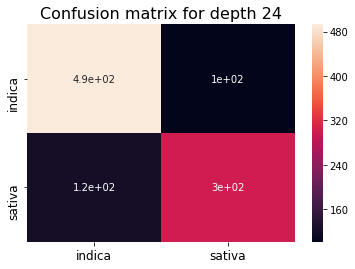

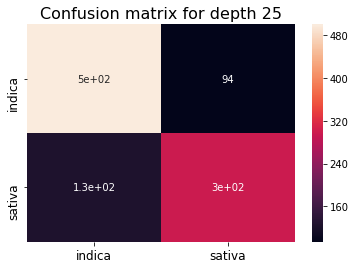

In [38]:
# Confusion Matrix
for i in range(0, max_depth):
    display_cf_matrix(RF_confusion_matrices, i)

Our confusion matrices are fairly consistent for most depths and, overall, do appear to be increasing. Do we dare see if this holds for, say a depth of 50 with 500 trees, as we did for hyrbid/sativa/indica strains?

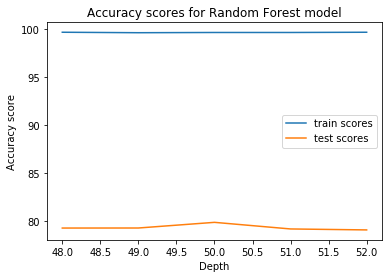

In [39]:
# Random Forest for Indica/Sativa classes, max_depth=25, n_trees = 200

sativa_indica_only = df[df['Strain_type'] != 'hybrid']

X = data_df_blind.loc[sativa_indica_only.index]
y = sativa_indica_only['Strain_type']

class_names = ['indica', 'sativa']

min_depth = 48
max_depth = 52
n_trees = 500

RF_model, RF_train_scores, RF_test_scores, RF_confusion_matrices = RF_iterate(X, y, max_depth, n_trees, class_names, min_depth=min_depth)

In [41]:
np.mean(RF_test_scores)

79.33682780042712

The test scores average 79.3%. Not as good as what we achieved for fewer trees at a lower depth, but at least they're consistent.

On average, our best scores for sativa/indica only for a random forest (~79.3%) is over 11% higher than for a single decision tree (~68.7%).

## 4. Most important features (terms)

What are the most critical features (terms) for our indica/sativa only RF model? Which words (or, more specifically, which lemmatized words) are helpful in distinguishing indica strains from sativa strains?

In [46]:
# EXPLORE MOST IMPORTANT FEATURES
top_features = 30

feature_list = list(data_df_blind.columns)

importances = list(RF_model.feature_importances_)
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

In [48]:
feature_importances

[('relax', 0.0255),
 ('sedat', 0.0236),
 ('insomnia', 0.0128),
 ('pain', 0.0121),
 ('uplift', 0.0116),
 ('energet', 0.0102),
 ('stimul', 0.0091),
 ('creativ', 0.0088),
 ('citrus', 0.0066),
 ('depress', 0.0062),
 ('bodi', 0.0057),
 ('og', 0.0054),
 ('heavi', 0.0052),
 ('kush', 0.005),
 ('daytim', 0.0049),
 ('deep', 0.0047),
 ('buzz', 0.0046),
 ('motiv', 0.0046),
 ('tropic', 0.0046),
 ('end', 0.0045),
 ('strain', 0.0045),
 ('focus', 0.0043),
 ('effect', 0.0042),
 ('energi', 0.0042),
 ('purpl', 0.004),
 ('couch', 0.0038),
 ('tall', 0.0038),
 ('grape', 0.0037),
 ('seed', 0.0037),
 ('berri', 0.0036),
 ('mood', 0.0036),
 ('dens', 0.0035),
 ('activ', 0.0032),
 ('sleep', 0.0031),
 ('fatigu', 0.003),
 ('flavor', 0.003),
 ('cross', 0.0029),
 ('high', 0.0029),
 ('bud', 0.0028),
 ('earthi', 0.0028),
 ('genet', 0.0028),
 ('pineappl', 0.0028),
 ('sweet', 0.0028),
 ('treat', 0.0028),
 ('calm', 0.0027),
 ('flower', 0.0027),
 ('cerebr', 0.0026),
 ('consum', 0.0026),
 ('dark', 0.0026),
 ('stress', 0.002

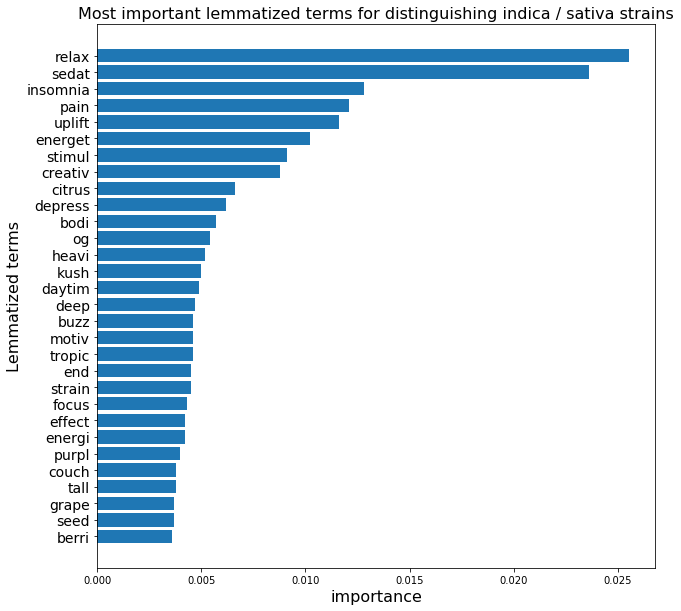

In [47]:
# VISUALIZE MOST IMPORTANT FEATURES

features = [feature_importances[i][0] for i in range(0,top_features)]
importances = [feature_importances[i][1] for i in range(0,top_features)]

plt.figure(figsize=(10,10))
plt.barh(y=features, width=importances)
plt.xlabel(xlabel="importance",fontsize=16)
plt.ylabel(ylabel="Lemmatized terms", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=14)
plt.title("Most important lemmatized terms for distinguishing indica / sativa strains", fontsize=16)
plt.gca().invert_yaxis()
plt.show()

From this list of terms we can immediately recognize some as being indicative of typically-associated effects, flavours, and medical uses for indica/sativa strains.

Before seeing which way these terms atually predict we might guess which way (indica/sativa) their TF-IDF value might 

For example, we know (from my previous work, among other sources) that indica strains are often described as relax[ing], sedat[ive], and good for imsomnia and pain, while sativas are often described as energet[ic], uplift[ing], creat[ive], citrus flavoured and good for depress[ion].

## Examine term strengh: 0.025 doesn't seem like a lot... what do these values mean?

## Look at word frequency, td-idf, for most important terms - what about most unique terms? How do do this...

## Look at most common n-grams?

Let's now take a moment and visualize one of our decision trees.

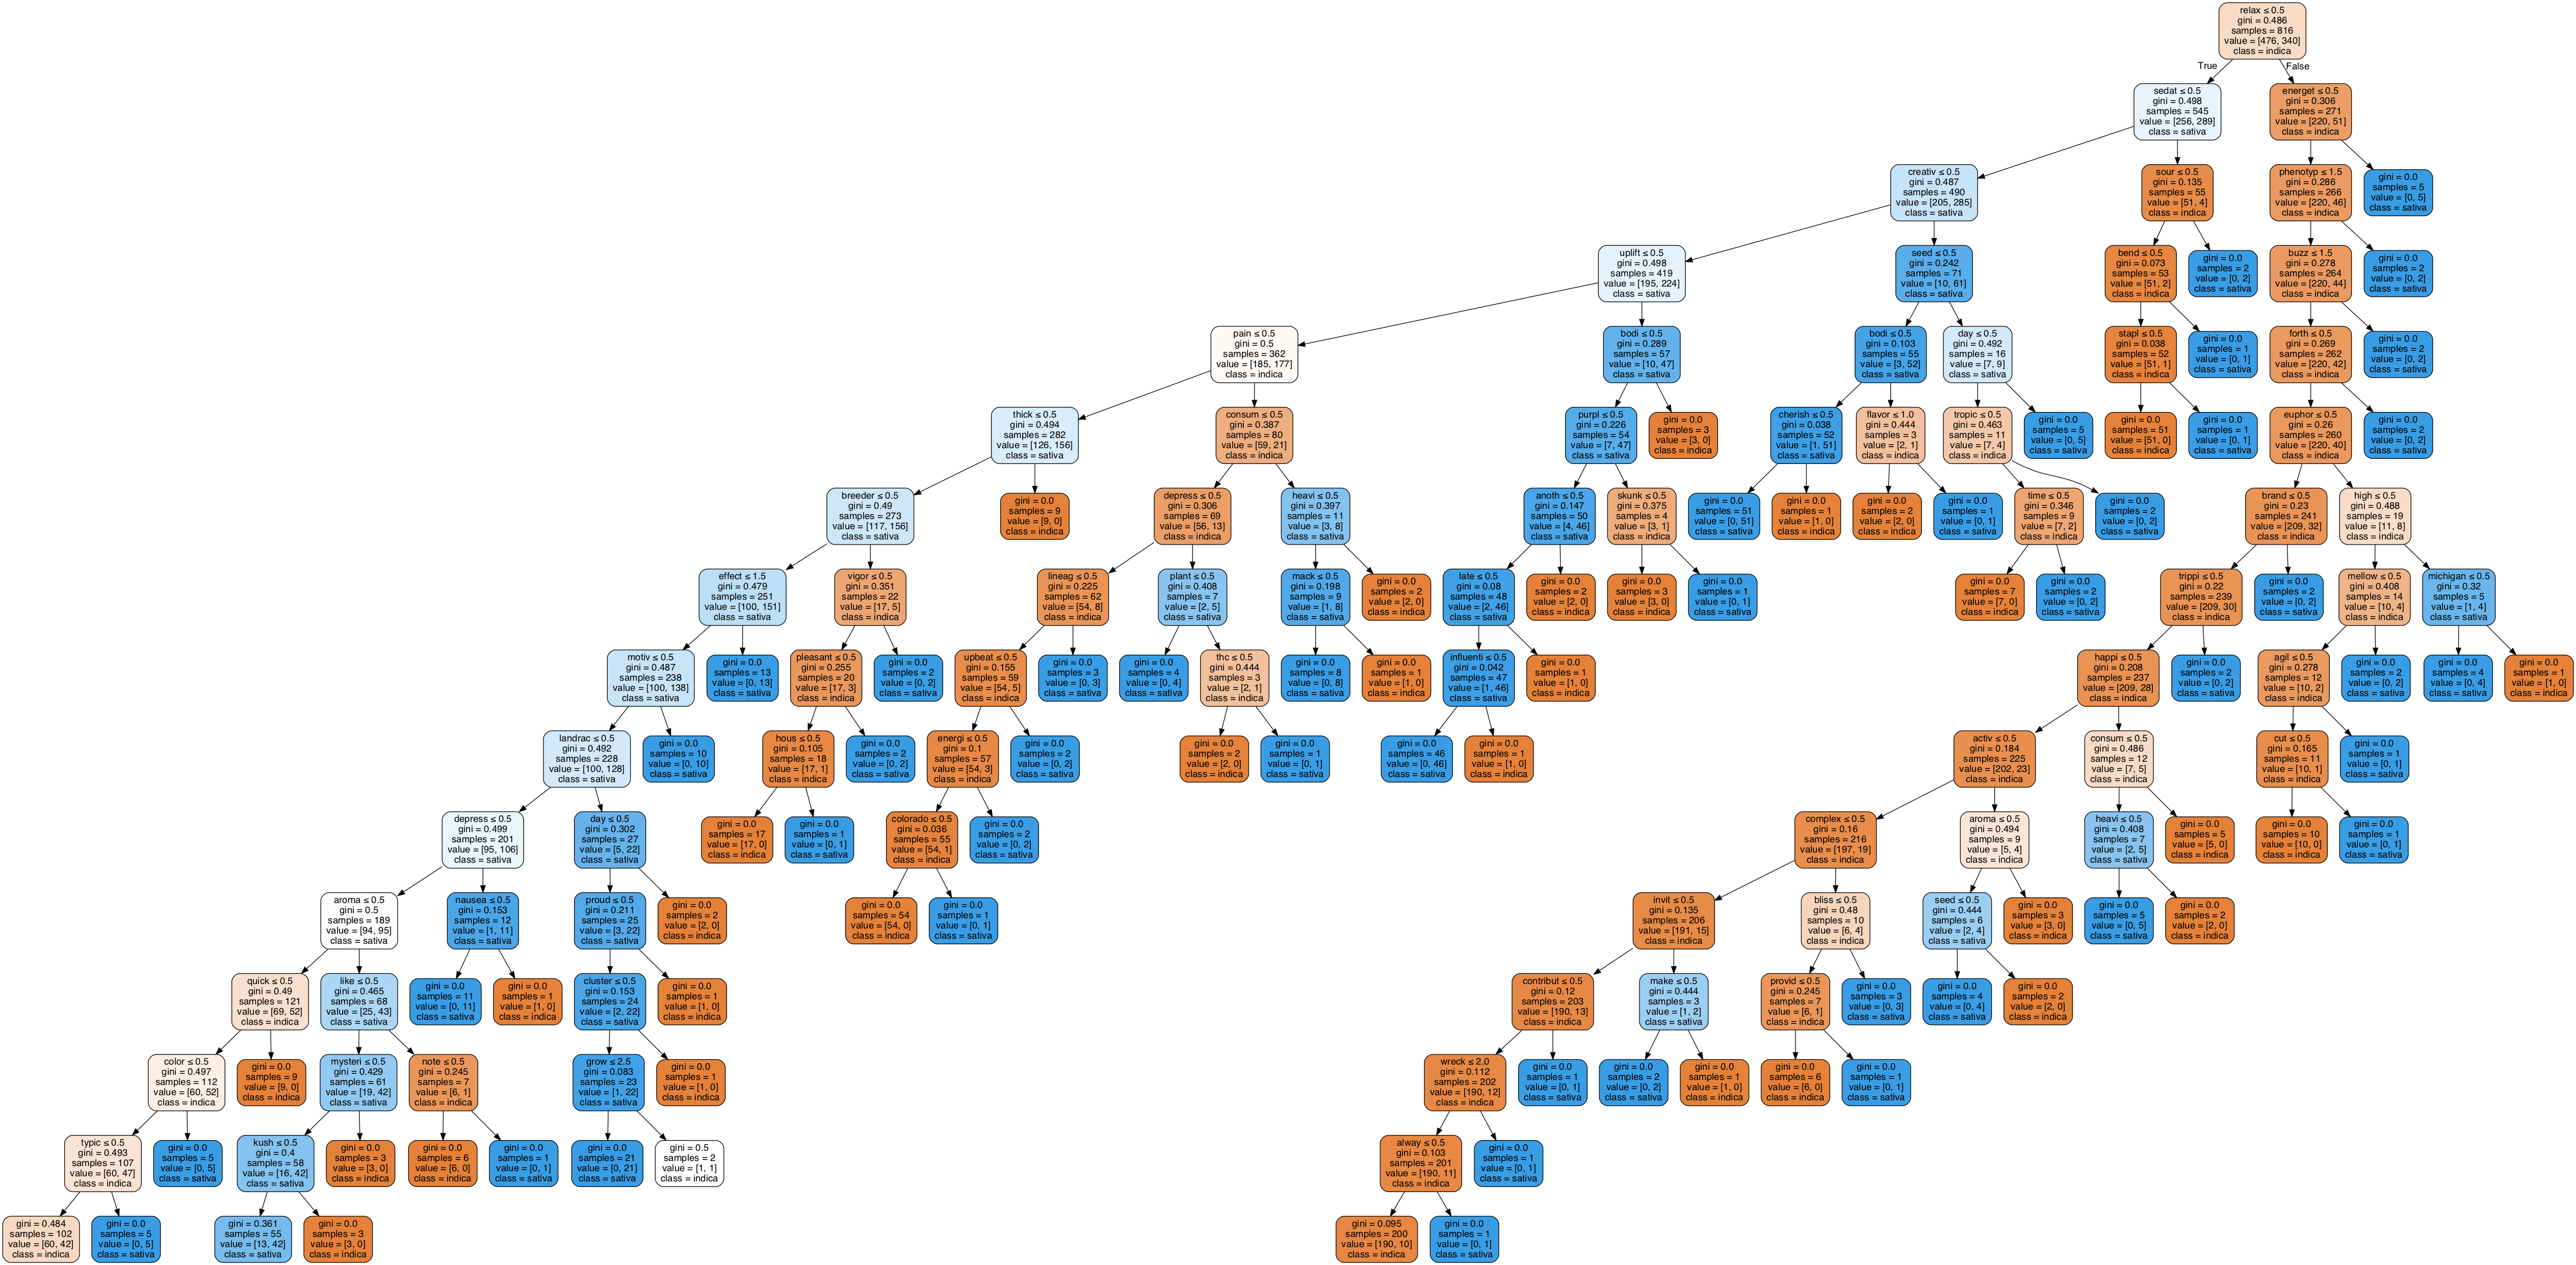

In [51]:
# VISUALIZE DECISION TREE

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(DT_model, out_file=dot_data, feature_names=data_df_blind.columns, class_names= DT_model.classes_, 
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())